<a href="https://colab.research.google.com/github/isarandi/metrabs/blob/master/metrabs_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MeTRAbs Absolute 3D Human Pose Estimator

István Sárándi, Timm Linder, Kai Oliver Arras, Bastian Leibe: "*MeTRAbs: Metric-Scale Truncation-Robust Heatmaps for Absolute 3D Human Pose Estimation.*"
In IEEE Transactions on Biometrics, Behavior, and Identity Science (T-BIOM), Selected Best Works From Automatic Face and Gesture Recognition (FG) 2020

* Repo: https://github.com/isarandi/metrabs
* Paper: https://arxiv.org/abs/2007.07227
* Conference talk: https://youtu.be/BemM8-Lx47g
* Qualitative result compilation: https://youtu.be/4VFKiiW9RCQ

In [ ]:
import tensorflow as tf
import os

def download_model(model_type):
    server_prefix = 'https://omnomnom.vision.rwth-aachen.de/data/metrabs'
    model_zippath = tf.keras.utils.get_file(
        origin=f'{server_prefix}/{model_type}_20211019.zip',
        extract=True, cache_subdir='models')
    model_path = os.path.join(os.path.dirname(model_zippath), model_type)
    return model_path

model = tf.saved_model.load(download_model('metrabs_mob3l_y4t')) # or metrabs_eff2l_y4 for the big model
! wget -q https://raw.githubusercontent.com/isarandi/metrabs/master/img/test_image_3dpw.jpg
image = tf.image.decode_jpeg(tf.io.read_file('test_image_3dpw.jpg'))

In [ ]:
pred = model.detect_poses(image, skeleton='smpl_24')

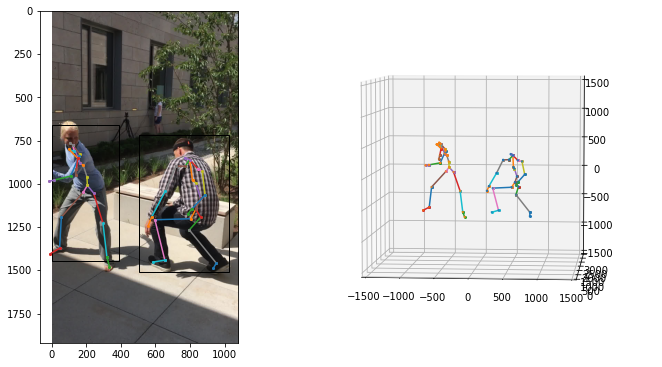

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

def visualize(im, detections, poses3d, poses2d, edges):
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image)
    for x, y, w, h in detections[:, :4]:
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -85)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(0, 3000)

    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # Therefore, we do a 90° rotation around the X axis:
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, poses2d):
        for i_start, i_end in edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)

    fig.tight_layout()
    plt.show()

visualize(
    image.numpy(), 
    pred['boxes'].numpy(),
    pred['poses3d'].numpy(),
    pred['poses2d'].numpy(),
    model.per_skeleton_joint_edges['smpl_24'].numpy())

## Predict with specified bounding boxes and intrinsics

You use your own intrinsic matrix and the bounding boxes (x_min, y_min, width, height) as follows:

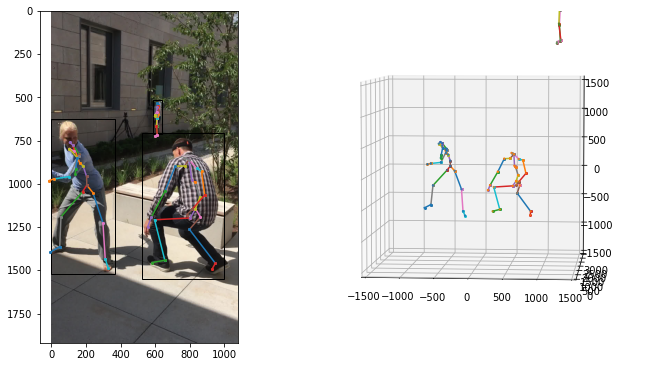

In [ ]:
intrinsic_matrix = tf.constant([[1962, 0, 540], [0, 1969, 960], [0, 0, 1]], dtype=tf.float32)
boxes = tf.constant([[0, 626, 367, 896], [524, 707, 475, 841], [588, 512, 54, 198]], tf.float32)
pred = model.estimate_poses(image, intrinsic_matrix=intrinsic_matrix, boxes=boxes, skeleton='smpl_24')
visualize(
    image.numpy(),
    boxes.numpy(),
    pred['poses3d'].numpy(),
    pred['poses2d'].numpy(),
    model.per_skeleton_joint_edges['smpl_24'].numpy())